In [32]:
# Imports
from matplotlib.pyplot import title
from math import sqrt
import streamlit as st
import datetime as dt
from datetime import datetime, timedelta
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from plotly import graph_objs as go
import pandas as pd
import vectorbt as vbt
import pandas_ta as ta
import pytz
from tqdm import tqdm
import numpy as np
import itertools

In [58]:
# Get the data
symbol = 'BTC-USD'

start_date = datetime(2010, 1, 1, tzinfo=pytz.utc)  # time period for analysis, must be timezone-aware
end_date = datetime(2022, 1, 31, tzinfo=pytz.utc)
time_buffer = timedelta(days=100)  # buffer before to pre-calculate SMA/EMA, best to set to max window
freq = '1D'

vbt.settings.portfolio['init_cash'] = 10_000.  # 10,000$
vbt.settings.portfolio['fees'] = 0.0025  # 0.25%
vbt.settings.portfolio['slippage'] = 0.0025  # 0.25%

cols = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_wbuf = vbt.YFData.download(symbol, start=start_date-time_buffer, end=end_date).get(cols)

ohlcv_wbuf = ohlcv_wbuf.astype(np.float64)
    
print(ohlcv_wbuf.shape)
print(ohlcv_wbuf.columns)

(2694, 5)
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [59]:
days = 365 # number of days to for forecast period
data = ohlcv_wbuf.copy()
column_name = 'Close'
cp_range = 1.0  #("Pct of data to train on", min_value=0.0, max_value=1.0, value=1.0) 
cp_scale = 0.2  #("Changepoint Scale", min_value=0.01, max_value=1.0, value=0.20) 
cp_num = 10     # ("Number of Changepoints", value=10) 

In [71]:
df_train = data[[column_name]]
df_train.index = df_train.index.tz_localize(None) # Prophet doesn't have timezone
df_train.reset_index(inplace=True) # Need to reset index to use prophet
df_train = df_train.rename(columns={"Date": "ds", column_name: "y"})
df_train["floor"] = 0.0
df_train["cap"] = 100_000   # cap is the maximum value of the forecast   
m = Prophet(changepoint_range=cp_range,changepoint_prior_scale=cp_scale, n_changepoints=int(cp_num))
m.fit(df_train)
future = m.make_future_dataframe(periods=days)
future["floor"] = 0.0
future["cap"] = 100_000
forecast = m.predict(future)

# Show and plot forecast
fig1 = plot_plotly(m, forecast)
fig1.layout.update(
    title_text=f"Forecasted For {symbol}", title_x = 0.5, title_y = .9
)
fig1.update_layout(margin_b=0, margin_t=0, margin_r=0,margin_l=0)
fig1.show()
# a = add_changepoints_to_plot(fig1,m,forecast)


2022-01-31 19:43:46.972 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5616.81     0.0908205       1206.83           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6005.38     0.0201419       288.924           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6026.88    0.00546928       99.4456           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6034.07    0.00162946       148.571        0.91        0.91      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       6034.55   0.000735806       77.7381   4.083e-05       0.001      499  LS failed, Hessian reset 
     459        6034.6   4.83584e-05    

In [72]:
print("Forecast data")
forecast



Forecast data


ds         trend     cap    yhat_lower    yhat_upper  \
0    2014-09-17   -116.207181  100000  -5885.145775   4568.958896   
1    2014-09-18   -114.204212  100000  -6491.779419   3831.627786   
2    2014-09-19   -112.201244  100000  -6066.983310   4127.931131   
3    2014-09-20   -110.198276  100000  -6668.446947   4308.209996   
4    2014-09-21   -108.195307  100000  -6573.999054   4224.233851   
...         ...           ...     ...           ...           ...   
3054 2023-01-27  46921.178451  100000  30446.849301  61820.704691   
3055 2023-01-28  46917.416319  100000  31294.139218  62536.042446   
3056 2023-01-29  46913.654186  100000  31045.222467  61846.191500   
3057 2023-01-30  46909.892054  100000  30981.971681  61450.206136   
3058 2023-01-31  46906.129922  100000  30599.157401  62806.039031   

       trend_lower   trend_upper  additive_terms  additive_terms_lower  \
0      -116.207181   -116.207181     -956.019746           -956.019746   
1      -114.204212   -114.204212    -1050.580503          -1050.580503   
2      -112.201244   -112.201244    -1087.160382          -1087.160382   
3      -110.198276   -110.198276    -1118.425804          -1118.425804   
4      -108.195307   -108.195307    -1167.774738          -1167.774738   
...            ...           ...             ...                   ...   
3054  32365.704828  61812.911348     -909.286824           -909.286824   
3055  32304.481043  61866.591863     -852.136264           -852.136264   
3056  32234.130543  61922.646282     -798.531576           -798.531576   
3057  32141.803178  61996.920783     -712.202110           -712.202110   
3058  32049.475813  62088.389915     -621.295223           -621.295223   

      additive_terms_upper     weekly  weekly_lower  weekly_upper  \
0              -956.019746  21.177866     21.177866     21.177866   
1             -1050.580503 -17.552097    -17.552097    -17.552097   
2             -1087.160382  -3.296247     -3.296247     -3.296247   
3             -1118.425804  10.530506     10.530506     10.530506   
4             -1167.774738  -0.195579     -0.195579     -0.195579   
...                    ...        ...           ...           ...   
3054           -909.286824  -3.296247     -3.296247     -3.296247   
3055           -852.136264  10.530506     10.530506     10.530506   
3056           -798.531576  -0.195579     -0.195579     -0.195579   
3057           -712.202110   1.357390      1.357390      1.357390   
3058           -621.295223 -12.021839    -12.021839    -12.021839   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0     -977.197612   -977.197612   -977.197612                   0.0   
1    -1033.028406  -1033.028406  -1033.028406                   0.0   
2    -1083.864135  -1083.864135  -1083.864135                   0.0   
3    -1128.956310  -1128.956310  -1128.956310                   0.0   
4    -1167.579159  -1167.579159  -1167.579159                   0.0   
...           ...           ...           ...                   ...   
3054  -905.990577   -905.990577   -905.990577                   0.0   
3055  -862.666770   -862.666770   -862.666770                   0.0   
3056  -798.335996   -798.335996   -798.335996                   0.0   
3057  -713.559500   -713.559500   -713.559500                   0.0   
3058  -609.273384   -609.273384   -609.273384                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  -1072.226926  
1                            0.0                         0.0  -1164.784715  
2                            0.0                         0.0  -1199.361626  
3                            0.0                         0.0  -1228.624079  
4                            0.0                         0.0  -1275.970045  
...                          ...                         ...           ...  
3054                         0.0                         0.0  46011.891627

2022-01-31 19:31:23.544 INFO    prophet: Making 9 forecasts with cutoffs between 2017-02-21 00:00:00 and 2021-01-31 00:00:00
  0%|          | 0/9 [00:00<?, ?it/s]

Initial log joint probability = -172.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       309.831   4.82105e-09       15.9159      0.0413      0.0413      101   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ericervin/anaconda3/envs/data-science/lib/python3.8/site-packages/prophet/forecaster.py:1287: RuntimeWarning:

overflow encountered in exp

 11%|█         | 1/9 [00:02<00:21,  2.63s/it]

Initial log joint probability = -70.8478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3140.75     0.0459872       959.062           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3181.92     0.0328714       327.711           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3196.04   0.000886142       70.1664      0.8395      0.8395      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       3197.75   6.15082e-05       23.7542   4.751e-06       0.001      486  LS failed, Hessian reset 
     399       3198.02    0.00682182       107.243           1           1      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        3203.6     0.0100359    

 22%|██▏       | 2/9 [00:06<00:23,  3.29s/it]

Initial log joint probability = -17.0066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2920.22     0.0497124       33.5882      0.4002           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       2926.07   0.000373702       60.3081   7.504e-06       0.001      228  LS failed, Hessian reset 
     199       2928.02     0.0917645       142.379           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2929.03   0.000104563       13.8835   2.985e-06       0.001      341  LS failed, Hessian reset 
     222       2929.44   0.000241645         23.39   9.676e-06       0.001      396  LS failed, Hessian reset 
     258       2931.44   0.000531735       49.8004   2.833e-06       0.001      484  LS failed, Hessian reset 
     298       2933.02   0.000228565       25.0764   1.681e-05   

 33%|███▎      | 3/9 [00:08<00:17,  2.95s/it]

Initial log joint probability = -16.0969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3147.38      0.118392       64.6263           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3147.47   0.000208742       61.2375   2.606e-06       0.001      165  LS failed, Hessian reset 
     163          3163   0.000156201       50.1968   2.548e-06       0.001      292  LS failed, Hessian reset 
     195       3164.21   0.000185871       52.7174   3.511e-06       0.001      364  LS failed, Hessian reset 
     199       3164.25    0.00162741       125.411           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3167.98     0.0151271       64.3924       2.432      0.2432      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 44%|████▍     | 4/9 [00:12<00:15,  3.04s/it]

Initial log joint probability = -25.309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3407.36    0.00767591        88.977           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       3429.82      0.001105       142.965   3.589e-06       0.001      195  LS failed, Hessian reset 
     199       3443.78     0.0166534       16.8273           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3455.46    0.00467424       27.5953           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       3455.79    0.00034502       50.0837   5.448e-06       0.001      473  LS failed, Hessian reset 
     394       3461.28   7.39991e-05       17.8094   1.107e-06       0.001      608  LS failed, Hessian reset

 56%|█████▌    | 5/9 [00:16<00:14,  3.57s/it]

Initial log joint probability = -21.1618
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3730.45    0.00588968       60.2109       23.07      0.2307      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3807.51      0.327229       926.324           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3854.19      0.130932       199.049           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3864.71     0.0689387       182.707      0.6594      0.6594      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       3868.98   0.000185327       174.605   7.142e-07       0.001      546  LS failed, Hessian reset 
     483       3871.81   0.000411112    

 67%|██████▋   | 6/9 [00:19<00:10,  3.41s/it]

Initial log joint probability = -20.5809
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3854.82     0.0165729       374.295      0.6222      0.6222      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3986.88      0.024405       576.491          10           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4420.46        6.3497       8579.31           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4546.57      0.017694       174.478      0.3895      0.3895      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4559.06     0.0120561       243.902           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

 78%|███████▊  | 7/9 [00:25<00:08,  4.21s/it]

Initial log joint probability = -21.8759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3882.28       1.67666       1575.84           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4102.72    0.00454643       280.307      0.1512     0.01512      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4144.85     0.0295072       83.0997           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4186.44      0.192084       220.997           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4192.58     0.0647715       200.697      0.7219      0.7219      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

 89%|████████▉ | 8/9 [00:29<00:04,  4.18s/it]

Initial log joint probability = -39.9479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5322.49     0.0707082       135.073           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5433.65     0.0369538       943.993           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5604.37      0.600497       1355.37           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5757.48      0.020567       107.716           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5784.4    0.00131204       431.051      0.7424      0.7424      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

100%|██████████| 9/9 [00:34<00:00,  3.86s/it]
2022-01-31 19:31:58.277 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/6 [00:00<?, ?it/s]

Initial log joint probability = -334.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       237.648     0.0100433       39.9376           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        252.35     0.0718273       164.534           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260        257.55   0.000334112       22.6489   1.556e-05       0.001      346  LS failed, Hessian reset 
     292        258.61   0.000926238       42.9825   8.199e-06       0.001      416  LS failed, Hessian reset 
     299       259.199     0.0122035       81.4344           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       260.011   0.000431453       25.8585   1.118e-05       0.001      512  LS failed, Hessian reset

 17%|█▋        | 1/6 [00:02<00:11,  2.31s/it]

Initial log joint probability = -414.126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1494.54     0.0518296       1061.16       0.689       0.689      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1712.58     0.0306883       165.024      0.9199      0.9199      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1838.97      0.150065       308.024           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1859.13    0.00227114        59.618           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1874.17     0.0830088       533.335           1           1      628   
    Iter      log prob        ||dx||      ||grad||       alpha  

 33%|███▎      | 2/6 [00:05<00:11,  2.96s/it]

Initial log joint probability = -7573.01
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2272.65     0.0455001       928.321           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2470.57    0.00762921       245.674           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2493.69     0.0028303       181.958      0.2616      0.2616      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2530.04    0.00585158       201.469           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2533.28    0.00776971       289.589           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

 50%|█████     | 3/6 [00:08<00:09,  3.00s/it]

Initial log joint probability = -16.0969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3147.38      0.118392       64.6263           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       3147.47   0.000208742       61.2375   2.606e-06       0.001      165  LS failed, Hessian reset 
     163          3163   0.000156201       50.1968   2.548e-06       0.001      292  LS failed, Hessian reset 
     195       3164.21   0.000185871       52.7174   3.511e-06       0.001      364  LS failed, Hessian reset 
     199       3164.25    0.00162741       125.411           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3167.98     0.0151271       64.3924       2.432      0.2432      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 67%|██████▋   | 4/6 [00:12<00:06,  3.12s/it]

Initial log joint probability = -25.4501
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3397.49     0.0033449       207.585      0.2838      0.2838      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3418.86      0.176388        294.74           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3437.13    0.00126153       86.6931   4.936e-06       0.001      295  LS failed, Hessian reset 
     299       3458.58     0.0079375       69.9863      0.7098      0.7098      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       3459.67   0.000717258       141.618   2.961e-06       0.001      455  LS failed, Hessian reset 
     381       3465.06   0.000597352       109.056    1.71e-06       0.001      565  LS failed, Hessian rese

 83%|████████▎ | 5/6 [00:16<00:03,  3.45s/it]

Initial log joint probability = -21.9269
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3913.9      0.266625       2001.55           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4113.26     0.0651539       542.057           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4151.42     0.0459684       234.559           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330       4152.46   0.000121696        83.463   1.153e-06       0.001      425  LS failed, Hessian reset 
     399       4162.56     0.0238008       92.8239           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4221.54    0.00175036    

100%|██████████| 6/6 [00:21<00:00,  3.60s/it]
/Users/ericervin/anaconda3/envs/data-science/lib/python3.8/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/Users/ericervin/anaconda3/envs/data-science/lib/python3.8/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



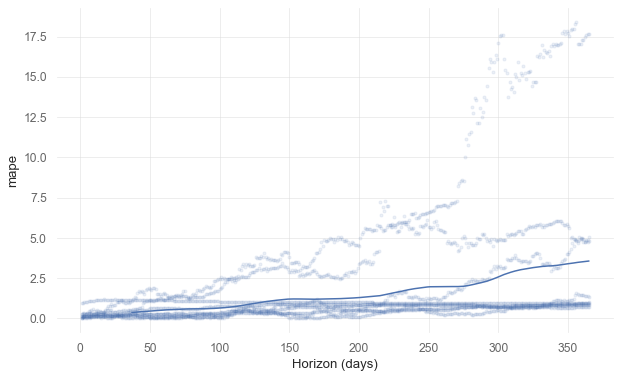

In [63]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric


df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
cutoffs = pd.to_datetime(['2015-02-15', '2016-08-15', '2017-02-15', '2018-08-15', '2019-02-15', '2020-08-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [64]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',

                         parallel="processes")

2022-01-31 19:33:04.611 INFO    prophet: Making 9 forecasts with cutoffs between 2017-02-21 00:00:00 and 2021-01-31 00:00:00
2022-01-31 19:33:04.615 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a1ad1c0>


Initial log joint probability = -70.8478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.0066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3140.75     0.0459872       959.062           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3181.92     0.0328714       327.711           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2920.22     0.0497124       33.5882      0.4002           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.0969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -172.581
    Iter      log prob 

/Users/ericervin/anaconda3/envs/data-science/lib/python3.8/site-packages/prophet/forecaster.py:1287: RuntimeWarning: overflow encountered in exp
  return cap / (1 + np.exp(-k_t * (t - m_t)))


     195       3164.21   0.000185871       52.7174   3.511e-06       0.001      364  LS failed, Hessian reset 
     199       3164.25    0.00162741       125.411           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       3204.66    0.00465231       30.6426      0.2886      0.2886      772   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       2933.02   0.000228565       25.0764   1.681e-05       0.001      569  LS failed, Hessian reset 
     299       2933.02    0.00021119       24.5919           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     652       3204.88   8.64607e-05       46.0632   1.121e-06       0.001      884  LS failed, Hessian reset 
     350       2933.51   9.61284e-05       15.7264   5.803e-06       0.001      673  LS failed, Hessian reset 
     299       3167

# Hyperparameter tuning

In [75]:

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

2022-01-31 19:46:46.699 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:46:47.488 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:46:47.489 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797d392d60>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       3670.72   0.000884785       2571.48   1.622e-07       0.001      167  LS failed, Hessian reset 
      99       3670.97   0.000246936       1887.28      0.8087      0.8087      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3672.52   1.08739e-05       2627.63   4.287e-09       0.001      281  LS failed, Hessian reset 
     194       3672.54   7.53374e-09       3840.11      0.3571           1      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -34.5118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -34.5118             0       893.836       1e-12       0.001       27   
Optimization terminated with error: 
  Line search fai

Iteration  1. Log joint probability =    251.763. Improved by 851.773.
Initial log joint probability = -22.7669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1126.25     0.0045222       5441.07      0.3666           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.3176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       1175.43   2.85585e-05       4703.79    5.75e-09       0.001      275  LS failed, Hessian reset 
     199       1175.48    5.0074e-06       4283.52      0.5957      0.5957      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       1175.53   9.08215e-09       4382.98      0.9068      0.9068      336   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
It

2022-01-31 19:47:07.081 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:47:08.502 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:47:08.505 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a55f340>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       3663.72    0.00106801       3333.81   2.339e-07       0.001      134  LS failed, Hessian reset 
      99       3665.22   1.94326e-06       2902.97      0.8885      0.8885      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3672.97    0.00502536       4741.18      0.2193           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       3689.64   0.000106541       3676.78   3.507e-08       0.001      512  LS failed, Hessian reset 
     299       3690.31   2.42367e-05       3618.56      0.4605           1      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       3690.52     4.048e-07       3664.62   1.034e-10       0.001      652  LS failed, Hessian rese

Initial log joint probability = -2.58125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       268.588    0.00302689       5011.07      0.3967      0.3967      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       274.569   9.97594e-09       5005.91      0.4484      0.4484      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.3176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.7669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1048.2   5.99751e-06       5446.24           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    489.132. I

2022-01-31 19:47:29.366 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:47:31.017 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:47:31.018 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a41e6a0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       3662.19   0.000228586          3599   5.737e-08       0.001      135  LS failed, Hessian reset 
      99       3663.08   5.39023e-05       2813.42           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       3667.42   0.000678478       2627.95   1.516e-07       0.001      251  LS failed, Hessian reset 
     149       3668.42   1.73547e-05       2490.81   5.872e-09       0.001      345  LS failed, Hessian reset 
     199       3668.82   0.000108834       2717.04           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       3684.01    9.9739e-05       4088.57   2.708e-08       0.001      564  LS failed, Hessian reset 
     299       3684.27   5.34451e-06        1749.7      0.4873   

      77       2317.92   0.000150644       4484.41   3.424e-08       0.001      132  LS failed, Hessian reset 
Iteration  1. Log joint probability =    520.133. Improved by 1239.88.
      99       2318.28     1.618e-06       5222.41      0.4185           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       2318.29   5.40958e-09       4383.38      0.4923      0.4923      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    1298.52. Improved by 778.383.
Iteration  3. Log joint probability =    1620.61. Improved by 322.09.
Iteration  4. Log joint probability =    1674.36. Improved by 53.7544.
Iteration  5. Log joint probability =    1696.77. Improved by 22.4046.
Iteration  6. Log joint probability =    1698.59. Improved by 1.82184.
Iteration  7. Log joint probability =    1704.79. Improved by 6.19978.
Iteration  8. Log join

2022-01-31 19:47:48.655 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:47:49.528 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:47:49.531 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7979f77940>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       3662.32   0.000227393       3493.22   9.101e-08       0.001      129  LS failed, Hessian reset 
      98       3662.67   1.58733e-05       3341.02   4.608e-09       0.001      219  LS failed, Hessian reset 
      99       3662.68   8.68056e-06       2747.73      0.8701      0.8701      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        3662.7   4.06851e-07       4280.56   1.506e-10       0.001      299  LS failed, Hessian reset 
     128        3662.7   2.48711e-08        2573.9   8.632e-12       0.001      350  LS failed, Hessian reset 
     129        3662.7   8.66943e-09       1606.07           1           1      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -22.7669
    Iter   

     150       2317.98   5.25141e-09       4204.99      0.3299      0.3299      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    520.478. Improved by 1300.09.
Iteration  2. Log joint probability =    1298.49. Improved by 778.014.
Iteration  3. Log joint probability =    1619.86. Improved by 321.372.
Iteration  4. Log joint probability =    1673.97. Improved by 54.1105.
Iteration  5. Log joint probability =    1696.75. Improved by 22.7743.
Iteration  6. Log joint probability =    1698.55. Improved by 1.8056.
Iteration  7. Log joint probability =    1704.77. Improved by 6.21819.
Iteration  8. Log joint probability =    1705.76. Improved by 0.983797.
Iteration  9. Log joint probability =    1709.15. Improved by 3.39647.
Iteration 10. Log joint probability =    1710.26. Improved by 1.11037.
Iteration 11. Log joint probability =    1710.52. Improved by 0.259769.
Initial log joint probabil

2022-01-31 19:48:06.545 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:48:08.129 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:48:08.131 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a2fa9a0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5129.98    0.00205532       296.948      0.7107      0.7107      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5143.16    0.00244721       957.209   4.823e-06       0.001      212  LS failed, Hessian reset 
     199       5149.24   7.64684e-05       330.204      0.2341           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5149.31   4.58914e-06       385.495      0.4909      0.4909      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       5149.32   1.12728e-05       394.339   2.863e-08       0.001      470  LS failed, Hessian reset 
     331       5149.32     4.805e-07       294.311   1.235e-09       0.001      542  LS failed, Hessian rese

2022-01-31 19:48:18.238 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:48:19.664 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:48:19.666 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7979fcacd0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5135.69    0.00324615       389.728       0.382       0.382      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       5153.17   0.000411926       388.948   1.021e-06       0.001      242  LS failed, Hessian reset 
     199       5153.32   0.000186631       305.526           1           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       5153.46   0.000111909       349.275   2.978e-07       0.001      358  LS failed, Hessian reset 
     299       5153.53   0.000264042        390.54           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       5154.06   0.000431775       407.638   1.013e-06       0.001      528  LS failed, Hessian rese

2022-01-31 19:48:27.815 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:48:28.713 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:48:28.715 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7979f77eb0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5136.85     0.0031385       918.345       0.203      0.7225      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198          5154   0.000463959       578.355   1.026e-06       0.001      289  LS failed, Hessian reset 
     199       5154.07   0.000154572       431.959           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       5154.16   7.08834e-08       334.868      0.3214           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.58125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       414.389   9.82858e-09       503.721      0.4076      0.40

2022-01-31 19:48:36.684 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:48:37.999 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:48:38.000 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7979fca4c0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5139.51     0.0032693       1107.19      0.2778           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       5151.25     0.0014063       557.342   3.203e-06       0.001      186  LS failed, Hessian reset 
     161       5153.49   0.000817331       595.295   1.476e-06       0.001      276  LS failed, Hessian reset 
     199       5153.79   1.36927e-07       333.239      0.4941      0.4941      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       5153.81   3.91871e-05       368.972   1.196e-07       0.001      403  LS failed, Hessian reset 
     268       5153.84   1.64037e-05       304.579    4.65e-08       0.001      500  LS failed, Hessian reset 
     298       5153.85   9.90235e-07       288.068   2.743e-09   

2022-01-31 19:48:46.376 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:48:48.455 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:48:48.457 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a55fbe0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5500.57      0.179403        985.52           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5532.38    0.00251098       93.1319       2.441      0.2441      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5544.64     0.0145514       546.896           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5560.18     0.0526438       530.424      0.3279           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       5560.42   0.000109823       92.7108   1.153e-06       0.001      512  LS failed, Hessian reset 
     499       5565.49    0.00319468    

2022-01-31 19:49:04.607 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:49:09.562 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:49:09.564 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a2fa970>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5509.24     0.0118075       218.047           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5544.69    0.00345261       304.318      0.3789      0.3789      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5557.31     0.0105999       145.036           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5570.72     0.0112126       286.186           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5573.84    0.00125097       96.8559      0.8345      0.8345      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

2022-01-31 19:49:32.001 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:49:35.321 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:49:35.323 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797bb1e040>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5508.51      0.036283        158.82       1.437      0.1437      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5537.32    0.00402281        270.78           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5550.57    0.00708612        99.441           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5563.91     0.0104154       389.465           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     453       5571.02   0.000325785       139.304   4.923e-06       0.001      555  LS failed, Hessian reset 
     499       5573.58     0.0117617    

2022-01-31 19:49:57.470 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:50:02.506 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:50:02.509 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a54e1c0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5503.05     0.0180974       222.171           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5542.88    0.00332496       106.456      0.6815      0.6815      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5558.48     0.0217922        205.65       1.817     0.01817      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5571.81     0.0186166       891.175           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5576.48   0.000438096       128.514      0.8373      0.8373      598   
    Iter      log prob        ||dx||      ||grad||       alpha  

2022-01-31 19:50:21.585 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:50:27.936 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:50:27.938 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a2fa910>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5566.01     0.0636426       1411.81           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5628.36    0.00928392        377.89      0.6917      0.6917      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5676.31     0.0402289       708.833      0.4404           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5694.42    0.00637689       132.957           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5704.81    0.00807371       332.663      0.1929           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

2022-01-31 19:50:47.896 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:50:54.441 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:50:54.443 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797a173b20>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5564.86    0.00708006       458.024      0.6266      0.6266      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5621.28     0.0349527       1388.62      0.3976      0.3976      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5674.36     0.0129923       335.503           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5726.74      0.078593        206.84           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5763.04    0.00983142       371.326           1           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha  

2022-01-31 19:51:15.059 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:51:21.634 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:51:21.636 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f797d392fa0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5561.82     0.0291295       374.697           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5628.39      0.104018       1147.82      0.3498           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5678.37      0.303319       873.978           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5730.45     0.0126082         117.2           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5760.61     0.0183465       189.566           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

2022-01-31 19:51:42.231 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-01-31 19:51:49.486 WARNING prophet: Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
2022-01-31 19:51:49.487 INFO    prophet: Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7979f77eb0>


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5582.61      0.137929       641.862           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5630.16    0.00336458       269.531           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5663.92     0.0029651       81.9004           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5714.25     0.0269727       173.042           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5725.6     0.0102293       275.024      0.5699      0.5699      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [77]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [74]:
m = Prophet(changepoint_range=cp_range,changepoint_prior_scale=0.5, seasonality_prior_scale=10.0, 
            n_changepoints=int(cp_num))

m.fit(df_train)
future = m.make_future_dataframe(periods=days)
# future["floor"] = 0
# future["cap"] = 150000
forecast = m.predict(future)

# Show and plot forecast
fig1 = plot_plotly(m, forecast)
fig1.layout.update(
    title_text=f"Forecasted For {symbol}", title_x = 0.5, title_y = .9
)
fig1.update_layout(margin_b=0, margin_t=0, margin_r=0,margin_l=0)
fig1.show()
# a = add_changepoints_to_plot(fig1,m,forecast)

2022-01-31 19:45:10.790 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5759.76     0.0470012       742.223       0.453           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6048.97    0.00278151       224.554           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6084.09   0.000927026       45.9689           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6088.49    0.00032228       64.0253      0.5926      0.5926      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6088.88   9.41943e-05       5.07425           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [79]:
forecast.head()

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2014-09-17 -261.226384 -7083.963546  3886.273154  -261.226384  -261.226384   
1 2014-09-18 -258.244056 -6673.946807  4292.855031  -258.244056  -258.244056   
2 2014-09-19 -255.261728 -6312.933989  3938.268249  -255.261728  -255.261728   
3 2014-09-20 -252.279399 -6373.757194  3819.534426  -252.279399  -252.279399   
4 2014-09-21 -249.297071 -6827.452781  3937.238000  -249.297071  -249.297071   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0     -944.579678           -944.579678           -944.579678  21.263449   
1    -1038.285667          -1038.285667          -1038.285667 -17.590735   
2    -1073.840986          -1073.840986          -1073.840986  -3.270176   
3    -1104.076731          -1104.076731          -1104.076731  10.657298   
4    -1152.507246          -1152.507246          -1152.507246  -0.037212   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0     21.263449     21.263449  -965.843127   -965.843127   -965.843127   
1    -17.590735    -17.590735 -1020.694932  -1020.694932  -1020.694932   
2     -3.270176     -3.270176 -1070.570809  -1070.570809  -1070.570809   
3     10.657298     10.657298 -1114.734029  -1114.734029  -1114.734029   
4     -0.037212     -0.037212 -1152.470034  -1152.470034  -1152.470034   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0 -1205.806061  
1                         0.0 -1296.529723  
2                         0.0 -1329.102713  
3                         0.0 -1356.356131  
4                         0.0 -1401.804317

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  1668.831735
1                     0.001                     0.10  1645.675692
2                     0.001                     1.00  1667.332289
3                     0.001                    10.00  1664.666766
4                     0.010                     0.01  1947.559618
5                     0.010                     0.10  1876.751068
6                     0.010                     1.00  1897.969480
7                     0.010                    10.00  1914.352476
8                     0.100                     0.01   721.292403
9                     0.100                     0.10   695.111453
10                    0.100                     1.00   691.973153
11                    0.100                    10.00   686.805754
12                    0.500                     0.01   593.485317
13                    0.500                     0.10   612.000676
14        

/var/folders/xc/rshdbzdj22z7vyxh3ht1rh480000gn/T/ipykernel_32941/1782497332.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



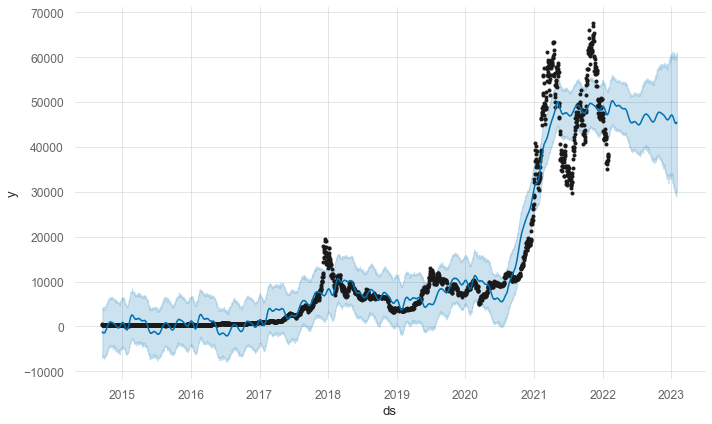

In [149]:
print(tuning_results)
print("Forecast components")
fig2 = m.plot(forecast, uncertainty=True)
fig2.show()

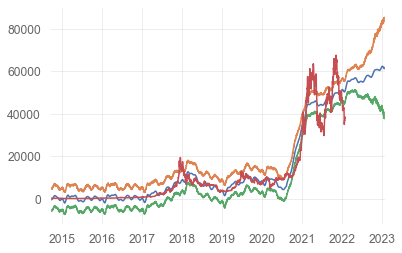

In [185]:
forecast.index = forecast.ds.values
forecast["yhat"].plot()
forecast["yhat_upper"].plot()
forecast["yhat_lower"].plot()
df_train.index = df_train.ds.values
df_train["y"].plot()

In [186]:
backtest = pd.merge(forecast[["ds","yhat"]], df_train[["ds","y"]], on="ds")
backtest

ds          yhat             y
0    2014-09-17    194.049564    457.334015
1    2014-09-18     72.294449    424.440002
2    2014-09-19      8.988098    394.795990
3    2014-09-20    -49.219143    408.903992
4    2014-09-21   -124.421367    398.821014
...         ...           ...           ...
2689 2022-01-27  50495.857505  37138.234375
2690 2022-01-28  50614.703735  37784.332031
2691 2022-01-29  50755.382576  38138.179688
2692 2022-01-30  50894.179534  37917.601562
2693 2022-01-31  51066.330277  38483.125000

[2694 rows x 3 columns]

In [187]:
backtest.set_index("ds", inplace=True)
backtest


yhat             y
ds                                    
2014-09-17    194.049564    457.334015
2014-09-18     72.294449    424.440002
2014-09-19      8.988098    394.795990
2014-09-20    -49.219143    408.903992
2014-09-21   -124.421367    398.821014
...                  ...           ...
2022-01-27  50495.857505  37138.234375
2022-01-28  50614.703735  37784.332031
2022-01-29  50755.382576  38138.179688
2022-01-30  50894.179534  37917.601562
2022-01-31  51066.330277  38483.125000

[2694 rows x 2 columns]

In [188]:
backtest

yhat             y
ds                                    
2014-09-17    194.049564    457.334015
2014-09-18     72.294449    424.440002
2014-09-19      8.988098    394.795990
2014-09-20    -49.219143    408.903992
2014-09-21   -124.421367    398.821014
...                  ...           ...
2022-01-27  50495.857505  37138.234375
2022-01-28  50614.703735  37784.332031
2022-01-29  50755.382576  38138.179688
2022-01-30  50894.179534  37917.601562
2022-01-31  51066.330277  38483.125000

[2694 rows x 2 columns]

In [223]:

entries = backtest["yhat"].vbt.crossed_above(backtest["y"])
print(entries.shape)

exits = backtest["yhat"].vbt.crossed_below(backtest["y"])
print(exits.shape)


pf = vbt.Portfolio.from_signals(backtest["y"], entries, exits)
pf.total_return()

(2694,)
(2694,)


454.6422614909074

In [224]:
fig = pf.plot() 
fig.show()

In [225]:
pf.stats()

Start                                2014-09-17 00:00:00
End                                  2022-01-31 00:00:00
Period                                2694 days 00:00:00
Start Value                                      10000.0
End Value                                 4556422.614909
Total Return [%]                            45464.226149
Benchmark Return [%]                         8314.664938
Max Gross Exposure [%]                             100.0
Total Fees Paid                            385875.346464
Max Drawdown [%]                               52.520075
Max Drawdown Duration                  872 days 00:00:00
Total Trades                                          65
Total Closed Trades                                   64
Total Open Trades                                      1
Open Trade PnL                            -971781.056072
Win Rate [%]                                     73.4375
Best Trade [%]                                349.350481
Worst Trade [%]                

In [227]:
cp_num = 25 
days = 30
m = Prophet(changepoint_range=cp_range,changepoint_prior_scale=0.5, seasonality_prior_scale=10.0, 
            n_changepoints=int(cp_num))

m.fit(df_train)
future = m.make_future_dataframe(periods=days)
# future["floor"] = 0
# future["cap"] = 150000
forecast = m.predict(future)

# Show and plot forecast
fig1 = plot_plotly(m, forecast)
fig1.layout.update(
    title_text=f"Forecasted For {symbol}", title_x = 0.5, title_y = .9
)
fig1.update_layout(margin_b=0, margin_t=0, margin_r=0,margin_l=0)
fig1.show()

2022-02-01 06:09:02.191 INFO    prophet: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -55.3438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5892.86     0.0878838       2643.47           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6228.59     0.0330308       1596.03      0.1898           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6379.64      0.109172       790.614           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6727.85      0.143182       1542.97           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7045.53     0.0385327       1932.06           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

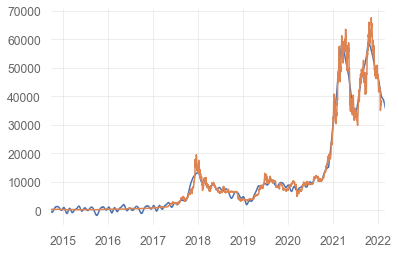

In [229]:
forecast.index = forecast.ds.values
forecast["yhat"].plot()
# forecast["yhat_upper"].plot()
# forecast["yhat_lower"].plot()
df_train.index = df_train.ds.values
df_train["y"].plot()

In [220]:
power = 0 # Use this as a multiplier/divisor for the forecasted values

backtest = pd.merge(forecast[["ds","yhat"]], df_train[["ds","y"]], on="ds")
print(backtest)
backtest.set_index("ds", inplace=True)

entries = backtest["y"].vbt.crossed_below(backtest["yhat"]*(1+power)) # When price is below forecasted price
print(entries.shape)

exits = backtest["y"].vbt.crossed_above(backtest["yhat"]*(1-power)) # When price is above forecasted price
print(exits.shape)

pf = vbt.Portfolio.from_signals(backtest["y"], entries, exits)
# pf.total_return()
pf.plot().show()
pf.stats()

             ds          yhat             y
0    2014-09-17    203.262456    457.334015
1    2014-09-18     50.850081    424.440002
2    2014-09-19    -43.454528    394.795990
3    2014-09-20   -130.418254    408.903992
4    2014-09-21   -234.535438    398.821014
...         ...           ...           ...
2689 2022-01-27  40429.092978  37138.234375
2690 2022-01-28  40260.408628  37784.332031
2691 2022-01-29  40110.433773  38138.179688
2692 2022-01-30  39953.764443  37917.601562
2693 2022-01-31  39828.882374  38483.125000

[2694 rows x 3 columns]
(2694,)
(2694,)


Start                                2014-09-17 00:00:00
End                                  2022-01-31 00:00:00
Period                                2694 days 00:00:00
Start Value                                      10000.0
End Value                                 4556422.614909
Total Return [%]                            45464.226149
Benchmark Return [%]                         8314.664938
Max Gross Exposure [%]                             100.0
Total Fees Paid                            385875.346464
Max Drawdown [%]                               52.520075
Max Drawdown Duration                  872 days 00:00:00
Total Trades                                          65
Total Closed Trades                                   64
Total Open Trades                                      1
Open Trade PnL                            -971781.056072
Win Rate [%]                                     73.4375
Best Trade [%]                                349.350481
Worst Trade [%]                

In [235]:
type(pf.stats()[3])

numpy.float64

In [251]:
pf.stats().iloc[3:20]



Start Value                         10000.0
End Value                    4556422.614909
Total Return [%]               45464.226149
Benchmark Return [%]            8314.664938
Max Gross Exposure [%]                100.0
Total Fees Paid               385875.346464
Max Drawdown [%]                  52.520075
Max Drawdown Duration     872 days 00:00:00
Total Trades                             65
Total Closed Trades                      64
Total Open Trades                         1
Open Trade PnL               -971781.056072
Win Rate [%]                        73.4375
Best Trade [%]                   349.350481
Worst Trade [%]                  -35.675289
Avg Winning Trade [%]             24.038668
Avg Losing Trade [%]              -8.870723
dtype: object

In [290]:
benchmark = backtest["y"].vbt.to_returns()

In [284]:
print(f"$100 invested in the strategy would have generated: ${pf.total_profit():,.2f} in total profit.")

$100 invested in the strategy would have generated: $4,546,422.61 in total profit.


In [295]:
pf.total_profit()

4546422.614909074

In [294]:
pf.stats(settings=dict(benchmark_rets=benchmark))

Start                                2014-09-17 00:00:00
End                                  2022-01-31 00:00:00
Period                                2694 days 00:00:00
Start Value                                      10000.0
End Value                                 4556422.614909
Total Return [%]                            45464.226149
Benchmark Return [%]                         8314.664938
Max Gross Exposure [%]                             100.0
Total Fees Paid                            385875.346464
Max Drawdown [%]                               52.520075
Max Drawdown Duration                  872 days 00:00:00
Total Trades                                          65
Total Closed Trades                                   64
Total Open Trades                                      1
Open Trade PnL                            -971781.056072
Win Rate [%]                                     73.4375
Best Trade [%]                                349.350481
Worst Trade [%]                

In [277]:
for k,v in pf.stats().items():
    print(k)
    if k.endswith("[%]"):
        print(f"{k}: {v:.2f}%")
    elif type(v) == np.float64:
        print(f"{k}: {v:.2f}")
    elif type(v) == np.int64:
        print(f"{k}: {v}")
    else:
        print(f"{k}" + ": " + str(v))

Start
Start: 2014-09-17 00:00:00
End
End: 2022-01-31 00:00:00
Period
Period: 2694 days 00:00:00
Start Value
Start Value: 10000.00
End Value
End Value: 4556422.61
Total Return [%]
Total Return [%]: 45464.23%
Benchmark Return [%]
Benchmark Return [%]: 8314.66%
Max Gross Exposure [%]
Max Gross Exposure [%]: 100.00%
Total Fees Paid
Total Fees Paid: 385875.35
Max Drawdown [%]
Max Drawdown [%]: 52.52%
Max Drawdown Duration
Max Drawdown Duration: 872 days 00:00:00
Total Trades
Total Trades: 65
Total Closed Trades
Total Closed Trades: 64
Total Open Trades
Total Open Trades: 1
Open Trade PnL
Open Trade PnL: -971781.06
Win Rate [%]
Win Rate [%]: 73.44%
Best Trade [%]
Best Trade [%]: 349.35%
Worst Trade [%]
Worst Trade [%]: -35.68%
Avg Winning Trade [%]
Avg Winning Trade [%]: 24.04%
Avg Losing Trade [%]
Avg Losing Trade [%]: -8.87%
Avg Winning Trade Duration
Avg Winning Trade Duration: 20 days 12:15:19.148936170
Avg Losing Trade Duration
Avg Losing Trade Duration: 21 days 19:45:52.941176470
Profi